# Predicting Titanic passenger survival
* Predicting whether a passenger on Titanic based on certain characteristics will survive the boat sinking or not.

## Step 1. Import libraries and the Titanic dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.exceptions import DataConversionWarning

from warnings import simplefilter

simplefilter(action='ignore', category=(FutureWarning, DataConversionWarning)) # ignore FutureWarnings

df = pd.read_csv('titanic_train.csv')

## Step 2. Exploratory Data Analysis
Gaining initial understanding about the data

In [2]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
def corr_heatmap(df):
    """ takes dataframe, shows relationships between different features """
    top_corr_features = df.corr().index
    plt.figure(figsize=(10,10))
    heatmap = sns.heatmap(df[top_corr_features].corr(), annot=True, cmap="RdYlGn")

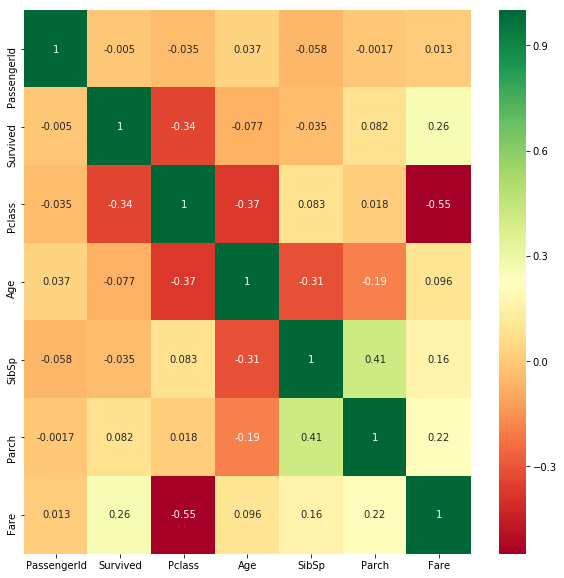

In [5]:
corr_heatmap(df)

[0, 250, 0, 330]

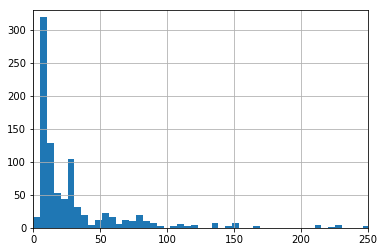

In [40]:
# visualize fare distribution -> normalize
df['Fare'].hist(bins=100)
plt.axis([0, 250, 0, 330], xaxis='price', yaxis='passengers')

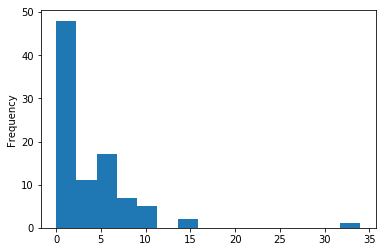

In [46]:
# distribution of age range for survived individuals -> children more likely to survive -> bin ages
df.groupby(df['Age'])['Survived'].sum().plot.hist(bins=15)

## Step 3. Feature Engineering
#### Inputation 
* Embarked - replace 3 missing values with the most occuring ones  
* Fare - fill with the mean age of Pclass
* Age - high correl with Pclass, replace with mean age in the Pclass
* Cabin - after feature engineering and model testing, cabin didn't improve accuracy score, column not added

#### Non-numeric data
* Sex - assign male=0, female=1
* Embarked - one-hot encode values

#### Non-normally distributed data

* Age - assign 4 categorical groups, use one-hot encoding
* Fare - scale with minmaxscaler

In [6]:
print("Amount of passengers Embarked=S:", df[df['Embarked'] == 'S'].count()['PassengerId'])
print("Amount of passengers Embarked=C:", df[df['Embarked'] == 'C'].count()['PassengerId'])
print("Amount of passengers Embarked=Q:", df[df['Embarked'] == 'Q'].count()['PassengerId'])
print("Share of Embarkations from S:", round(644*100/(644+168+77), 2), "%")

Amount of passengers Embarked=S: 644
Amount of passengers Embarked=C: 168
Amount of passengers Embarked=Q: 77
Share of Embarkations from S: 72.44 %


In [7]:
def feature_engineering(df_name):
    
    """ Data Wrangling """
    
    # 1. filling NaNs
    
    df_name['Embarked'].fillna(value='S', inplace=True)
    df_name['Fare'] = df_name['Fare'].fillna(df_name.groupby('Pclass')['Fare'].transform('mean'))
    df_name['Age'] = df_name['Age'].fillna(df_name.groupby('Pclass')['Age'].transform('mean'))
    
    # 2. Assigning sex numeric binary values, one-hot encode embarked
    
    df_name['Sex'] = pd.factorize(df_name['Sex'])[0] 
    df_name = pd.DataFrame.join(df_name, pd.get_dummies(df_name['Embarked']), how='outer')
    
    # 3. Scaling non-normal data   
    df_name['binned_ages'] = pd.qcut(df_name['Age'], q=4, labels=['under_20', '20_to_40', '40_to_60', 'over_60'])
    df_name = pd.DataFrame.join(df_name, pd.get_dummies(df_name['binned_ages']), how='outer')
    
    scaler = MinMaxScaler(feature_range=(0.0000000001,1))
    df_name['Pclass_scaled'] = scaler.fit_transform(np.array(df_name['Pclass']).reshape(-1,1))
    df_name['fare_scaled'] = scaler.fit_transform(np.array(df_name['Fare']).reshape(-1,1))
    
    # 4. Interaction terms 
    def sib_parch(row):
        if row['SibSp'] + row['Parch'] == 0:
            return int(0)
        elif row['SibSp'] == 1 and row['Parch'] == 0:
            return int(1)
        elif row['SibSp'] == 0 and row['Parch'] == 1:
            return int(1)
        elif row['SibSp'] > 1 and row['Parch'] > 1:
            return int(3)
        else:
            return int(2)
    df_name['family_categ'] = df_name.apply(sib_parch, axis=1)
    df_name['family_size'] = df_name.apply(sib_parch, axis=1).replace(to_replace={0: 'no_fam', 1:'small_fam', 
                                                                                  2: 'med_fam', 3: 'big_fam'})
    df_name = pd.DataFrame.join(df_name, pd.get_dummies(df_name['family_size']), how='outer')
    return df_name

## Step 4. Building and evaluating the model

### 4.1 Logistic regression

In [8]:
df = feature_engineering(pd.read_csv('titanic_train.csv'))

In [9]:
X_log = df[['Pclass', 'no_fam', 'small_fam', 'med_fam', 'big_fam', 'SibSp', 'Parch','Age', 
             'Fare', 'Sex', 'C', 'Q', 'S', 'under_20', '20_to_40', '40_to_60', 'over_60']] 
y_log = df['Survived']
Xtrain_log, Xtest_log, ytrain_log, ytest_log = train_test_split(X_log, y_log, test_size=0.2, random_state=42)

# Fitting a model
m_log = LogisticRegression(solver='newton-cg',tol=0.1) 
m_log.fit(Xtrain_log, ytrain_log)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.1, verbose=0, warm_start=False)

#### Model evaluation

In [10]:
def evaluate_model(model, xtrain, xtest, ytrain, ytest):
    """ prints out evaluation metrics for train and test sets """
    print('Test data evaluation results:\n')
    print(f'R-squared: {model.score(xtrain, ytrain).round(4)}')
    print(f'Cross validation mean: {cross_val_score(model, xtrain, ytrain, cv=5).mean().round(4)}')

    print(f'Precision: {precision_score(ytrain, model.predict(xtrain)).round(4)}')
    print(f'Recall: {recall_score(ytrain, model.predict(xtrain)).round(4)}\n')

    print('Test data evaluation results:\n')
    print(f'R-squared: {model.score(xtest, ytest).round(4)}')
    
    print(f'Precision: {precision_score(ytest, model.predict(xtest)).round(4)}')
    print(f'Recall: {recall_score(ytest, model.predict(xtest)).round(4)}')

In [11]:
evaluate_model(m_log, Xtrain_log, Xtest_log, ytrain_log, ytest_log)

Test data evaluation results:

R-squared: 0.8104
Cross validation mean: 0.8062
Precision: 0.7759
Recall: 0.6978

Test data evaluation results:

R-squared: 0.7989
Precision: 0.7794
Recall: 0.7162


### 4.2 Support vector machine

In [34]:
X_svc = df[['Pclass_scaled', 'family_categ', 'Sex', 'C', 'Q', 'S', 'fare_scaled', 'under_20', '20_to_40', '40_to_60', 'over_60']]
y_svc = df['Survived']

Xtrain_svc, Xtest_svc, ytrain_svc, ytest_svc = train_test_split(X_svc, y_svc, test_size=0.2, random_state=42)
m_svc = SVC(kernel='sigmoid', C=9.0, gamma=0.01)
m_svc.fit(Xtrain_svc, ytrain_svc)

SVC(C=9.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [35]:
evaluate_model(m_svc, Xtrain_svc, Xtest_svc, ytrain_svc, ytest_svc)

Test data evaluation results:

R-squared: 0.7879
Cross validation mean: 0.788
Precision: 0.7388
Recall: 0.6754

Test data evaluation results:

R-squared: 0.7821
Precision: 0.7536
Recall: 0.7027


## Step 5. Submit to Kaggle

Predicting passenger survival on Kaggle predict.csv data gives us accuracy=0.76555 for both models. 

In [36]:
df_kaggle = feature_engineering(pd.read_csv('predict.csv'))
ypred_kaggle_log = m_log.predict(df_kaggle[X_log.columns])
ypred_kaggle_svc = m_svc.predict(df_kaggle[X_svc.columns])

In [38]:
result1 = pd.DataFrame({'Survived': ypred_kaggle_log}, index=df_kaggle['PassengerId'])
result1.to_csv('yprediction_kaggle_log.csv')
result2 = pd.DataFrame({'Survived': ypred_kaggle_svc}, index=df_kaggle['PassengerId'])
result2.to_csv('yprediction_kaggle_svc.csv')